In [52]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path

import keras_tuner
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.src.layers import Dropout
from keras.src.layers import Dense
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from src.metrics.ece import ece

In [53]:
def interpolate_indexed_value_array(indexing_array: np.ndarray, value_array: np.ndarray, searched_for, strategy="linear"):
    f = interp1d(indexing_array, value_array, kind=strategy,
                 bounds_error=False, fill_value=(value_array[0], value_array[-1]))
    return f(searched_for)


def safe_unpickle_all(file):
    objects = []
    unpickler = pickle.Unpickler(file)
    while True:
        try:
            obj = unpickler.load()
            objects.append(obj)
        except EOFError:
            break  # End of file (incomplete last object)
        except Exception as e:
            print("Partial data recovered. Stopped at error:", e)
            break
    return objects

def build_nn(hp) -> keras.Model:
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hp.Int('num_layers', 5, 14)):
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=256, max_value=1536, step=32),
                activation=hp.Choice(f"activation_{i}", ["relu", "linear"]),
            )
        )
    model.add(Dense(1, activation="relu"))
    model.add(Dropout(hp.Float("Dropout", 0.05, 0.25, sampling='log')))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-5, 5e-4, sampling='log')

    optimizer = None
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.LogCosh,
        metrics=["mae", "mse"],
    )
    return model

In [54]:
# Gather Data from different files
print("Gathering data...")
data = []
dirs = ["./data/20250512_165251", "./data/20250511_095828", "./data/20250512_012245", "./data/20250510_185507", "./data/20250514_152839"]

for dir in dirs:
    files = Path(dir).glob("*.pkl")
    for file_name in files:
        print(file_name, sep=", ")
        with (open(f'{file_name}', 'rb') as file):
            try:
                content = pickle.load(file)
            except EOFError:
                print("Data is corrupted. Trying to partially recover data...")
                content = safe_unpickle_all(file)
                print(content)

            data = data + content

Gathering data...
data\20250512_165251\batch_0.pkl
data\20250512_165251\batch_1.pkl
data\20250512_165251\batch_10.pkl
data\20250512_165251\batch_11.pkl
data\20250512_165251\batch_12.pkl
data\20250512_165251\batch_13.pkl
data\20250512_165251\batch_14.pkl
data\20250512_165251\batch_15.pkl
data\20250512_165251\batch_16.pkl
data\20250512_165251\batch_17.pkl
data\20250512_165251\batch_18.pkl
data\20250512_165251\batch_19.pkl
data\20250512_165251\batch_2.pkl
data\20250512_165251\batch_20.pkl
data\20250512_165251\batch_21.pkl
data\20250512_165251\batch_22.pkl
data\20250512_165251\batch_23.pkl
data\20250512_165251\batch_24.pkl
data\20250512_165251\batch_25.pkl
data\20250512_165251\batch_26.pkl
data\20250512_165251\batch_27.pkl
data\20250512_165251\batch_28.pkl
data\20250512_165251\batch_29.pkl
data\20250512_165251\batch_3.pkl
data\20250512_165251\batch_30.pkl
data\20250512_165251\batch_31.pkl
data\20250512_165251\batch_4.pkl
data\20250512_165251\batch_5.pkl
data\20250512_165251\batch_6.pkl
dat

In [55]:
model_results = []
y_tests = []
p_tests = []
eces = []
sample_sizes = []
accuracies = []
y = []
optimal_eces = []
for result in data:
    model_result = result["model_results"]
    model_results = model_results + model_result
    
    for r in model_result:
        p_tests.append(r["p_test"])
        eces.append(r["ECEs"])
        accuracies.append(r["Accuracy"])
        y.append(r["Optimal Sample Size"])
        optimal_eces.append(r["Optimal ECE"])

    for i in range(4):
        y_tests.append(result["y_test"])
        sample_sizes.append(result["Sample Sizes"])

# Ensure numpy
y_tests = np.array(y_tests)
eces = np.array(eces)
p_tests = np.array(p_tests)
sample_sizes = np.array(sample_sizes)
accuracies = np.array(accuracies)
y = np.array(y)
optimal_eces = np.array(optimal_eces)

mean_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

dist_from_eces0 = np.array([np.linalg.norm(eces[0] - eces[i]) for i in range(len(eces)) if i != 0])

In [56]:
print("y_tests shape", y_tests.shape)
print("sample sizes shape", sample_sizes.shape)
print("p_tests shape", p_tests.shape)
print("eces shape", eces.shape)
print("Mean Accuracy", mean_accuracy)
print("Std. Dev. Accuracy", std_dev_accuracy)
print("Distances from eces[0]", dist_from_eces0)
print("Mean distance from eces[0]", np.mean(dist_from_eces0))
print("Std. Dev distance from eces[0]", np.std(dist_from_eces0))

print("Mean True ECE", np.mean(np.array([result["True ECE Dists (Binned - 15 Bins)"] for result in model_results])))
print("Std. Dev True ECE", np.std(np.array([result["True ECE Dists (Binned - 15 Bins)"] for result in model_results])))

print(sample_sizes)
print(eces)

y_tests shape (19776, 10000)
sample sizes shape (19776, 100)
p_tests shape (19776, 10000, 2)
eces shape (19776, 100)
Mean Accuracy 0.555453473907767
Std. Dev. Accuracy 0.06581432377886429
Distances from eces[0] [0.09544331 0.07870097 0.53808696 ... 0.11248307 0.13838289 0.3775371 ]
Mean distance from eces[0] 0.1957774660624265
Std. Dev distance from eces[0] 0.21457891506649068
Mean True ECE 0.021100714569096218
Std. Dev True ECE 0.027181341615156264
[[  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 10000]
 ...
 [  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 10000]]
[[0.01641349 0.01155017 0.01527441 ... 0.01042838 0.010213   0.00919354]
 [0.07789394 0.02331811 0.01552    ... 0.00339071 0.00372824 0.00521999]
 [0.04876041 0.01680131 0.00644943 ... 0.00459064 0.00399663 0.00364787]
 ...
 [0.09153866 0.03105002 0.03606263 ... 0.01756503 0.017863

In [57]:
# Prepare Data
X = np.hstack((sample_sizes, eces, accuracies.reshape(-1, 1)))
y = np.column_stack((y, optimal_eces))

print(X)

[[1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 1.02129970e-02
  9.19354276e-03 5.31600000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 3.72823966e-03
  5.21998996e-03 5.27800000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 3.99663319e-03
  3.64787243e-03 5.26200000e-01]
 ...
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 1.78635386e-02
  1.75702003e-02 7.16800000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 2.32899411e-02
  2.33424322e-02 7.16300000e-01]
 [1.00000000e+02 2.00000000e+02 3.00000000e+02 ... 4.61424242e-02
  4.61050000e-02 6.93200000e-01]]


In [58]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

optimal_eces_train = y_train[:, 1]
y_train = y_train[:, 0]
optimal_eces_test = y_test[:, 1]
y_test = y_test[:, 0]

X_train = X_train[:, 100:]
X_test = X_test[:, 100:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

print("y_train Shape", y_train.shape)
print("y_test Shape", y_test.shape)


X_train Shape (15820, 101)
X_test Shape (3956, 101)
y_train Shape (15820,)
y_test Shape (3956,)


In [72]:
# Perform Bayes Optimization
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_nn,
    objective="val_loss",
    max_trials=24,
    executions_per_trial=1,
    directory="keras_tuner_logs_bayes_logcosh_dropout_only_ece_values",
    project_name="ece_neural_network_bayes2_logscosh_dropout_only_ece_values",
)
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=128,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

best_model = tuner.get_best_models(num_models=1)[0]
y_pred_scaled = np.array(best_model.predict(X_test)).flatten()
y_pred = y_pred_scaled
print("y_pred_scaled NN", y_pred_scaled)

# Print best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key in best_hps.values.keys():
    print(f"{key}: {best_hps.get(key)}")

"""
model = keras.Sequential()
model.add(keras.layers.Flatten())
for i in range(4):
    model.add(
        Dense(
            units=480,
            activation="relu",
        )
    )
model.add(Dense(1, activation="linear"))

learning_rate = 0.0022035143136497045

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.LogCosh(),
    metrics=["mae"],
)

model.fit(X_train_scaled, y_train_scaled)
y_pred = y_scaler.inverse_transform(np.array(model.predict(X_test_scaled)).flatten().reshape(-1, 1)).ravel()
"""

print("y_pred NN", y_pred)

Trial 24 Complete [00h 25m 33s]
val_loss: 1402.285400390625

Best val_loss So Far: 1332.133056640625
Total elapsed time: 07h 11m 45s


C:\Users\Moritz\PycharmProjects\bachelor_thesis\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
y_pred_scaled NN [ 332.46695 6126.0283  4223.9277  ...  525.0288  2485.2249  1792.3265 ]
Best Hyperparameters:
num_layers: 12
units_0: 352
activation_0: linear
units_1: 768
activation_1: linear
units_2: 736
activation_2: relu
units_3: 384
activation_3: relu
units_4: 320
activation_4: linear
Dropout: 0.08567001415015699
optimizer: adam
learning_rate: 0.00012088243860862766
units_5: 800
activation_5: linear
units_6: 1280
activation_6: linear
units_7: 832
activation_7: linear
units_8: 1536
activation_8: linear
units_9: 512
activation_9: linear
units_10: 672
activation_10: linear
units_11: 704
activation_11: relu
units_12: 1184
activation_12: relu
units_13: 1056
activation_13: relu
y_pred NN [ 332.46695 6126.0283  4223.9277  ...  525.0288  2485.2249  1792.3265 ]


In [77]:
# Train Regressor
model = XGBRegressor(
    n_estimators=1000,
    max_depth=16,
    learning_rate=0.002,
    subsample=0.78,
    colsample_bytree=0.75,
    gamma=1,
    reg_alpha=0.15,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)
model.fit(X_train, y_train)
y_pred_scaled_regressor = np.array(model.predict(X_test)).flatten()
y_pred_regressor = y_pred_scaled_regressor
print("y_pred_scaled regressor", y_pred_scaled_regressor)
print("y_pred_regressor", y_pred_regressor)

KeyboardInterrupt: 

In [76]:
# Calculate Metrics and display Dataframe
print("X_test", X_test)
X_test_eces = X_test[:, :100]
print("X_test_eces", X_test_eces)
print("Sample Sizes", sample_sizes)


simple_strategy_preds = [
    (f"{(i + 1) * 100} Samples", (sample_sizes[len(X_train):, i], X_test_eces[:, i])) for i in [0, 4, 9, 19, 49, 79, 99]]

def get_rounded_clipped_sample_size(sample_size):
    return max(15, min(10000, round(sample_size)))

preds = {}
for pred in simple_strategy_preds:
    preds[pred[0]] = pred[1]


ece_nn_interpolated = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size) for
                                (i, sample_size) in enumerate(y_pred)])


ece_regressor_interpolated = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size) for
                      (i, sample_size) in enumerate(y_pred_regressor)])

ece_nn_interpolated_quad = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size, strategy="quadratic") for
                      (i, sample_size) in enumerate(y_pred)])

ece_regressor_interpolated_quad = np.array([interpolate_indexed_value_array(sample_sizes[i], X_test_eces[i], sample_size, strategy="quadratic") for
                                      (i, sample_size) in enumerate(y_pred_regressor)])
preds.update({
    "Neural Network": (
        y_pred, np.array([ece(p_tests[i][:get_rounded_clipped_sample_size(sample_size)], y_tests[i][:get_rounded_clipped_sample_size(sample_size)], n_bins=15) for
                          i, sample_size in enumerate(y_pred)])),
    "XGBRegressor": (y_pred_regressor,
                     np.array([ece(p_tests[i][:get_rounded_clipped_sample_size(sample_size)], y_tests[i][:get_rounded_clipped_sample_size(sample_size)], n_bins=15) for
                               i, sample_size in enumerate(y_pred_regressor)])),
    "Neural Network (Interpolated)": (y_pred, ece_nn_interpolated),
    "XGBRegressor (Interpolated)": (y_pred_regressor, ece_regressor_interpolated),
    "Interpolated Average": ((y_pred + y_pred_regressor)/ 2, (ece_nn_interpolated + ece_regressor_interpolated) / 2),
    "Neural Network (Interpolated - Quadratic)": (y_pred, ece_nn_interpolated_quad),
    "XGBRegressor (Interpolated - Quadratic)": (y_pred_regressor, ece_regressor_interpolated_quad),
    "Interpolated (Quadratic) Average": ((y_pred + y_pred_regressor) / 2, (ece_nn_interpolated_quad + ece_regressor_interpolated_quad) / 2),
    "Y_Test": (y_test, optimal_eces_test)
})

print("Optimal ECEs", optimal_eces_test)
print("y_test", y_test)
# Compute stats
results = []
for name, (sample_sizes_, eces) in preds.items():
    print(name, sample_sizes_, eces)
    results.append({
        "Name": name,
        "Mean (Samples)": np.mean(sample_sizes_),
        "Std Dev (Samples)": np.std(sample_sizes_),
        "MSE (Samples)": mean_squared_error(y_test, sample_sizes_),
        "MAE (Samples)": mean_absolute_error(y_test, sample_sizes_),
        "R2-Score (Samples)": r2_score(y_test, sample_sizes_),
        "Mean (ECE)": np.mean(eces),
        "Std Dev (ECE)": np.std(eces),
        "MSE (ECE)": mean_squared_error(optimal_eces_test, eces),
        "MAE (ECE)": mean_absolute_error(optimal_eces_test, eces),
        "R2-Score (ECE)": r2_score(optimal_eces_test, eces),
    })

# Create DataFrame
pd.set_option('display.max_columns', None)
df = pd.DataFrame(results)
print(df) 

X_test [[0.1461     0.1164     0.08853333 ... 0.08610202 0.086295   0.5155    ]
 [0.02562025 0.03045673 0.022956   ... 0.00644509 0.00590577 0.5489    ]
 [0.09838545 0.04729492 0.04730989 ... 0.00441511 0.00504029 0.5222    ]
 ...
 [0.02378072 0.02038872 0.02624856 ... 0.01386647 0.01392001 0.5767    ]
 [0.03379824 0.01386924 0.0294122  ... 0.00641819 0.0063439  0.5613    ]
 [0.06109172 0.06333306 0.05884621 ... 0.01616063 0.01573963 0.6399    ]]
X_test_eces [[0.1461     0.1164     0.08853333 ... 0.08588878 0.08610202 0.086295  ]
 [0.02562025 0.03045673 0.022956   ... 0.00633574 0.00644509 0.00590577]
 [0.09838545 0.04729492 0.04730989 ... 0.00484673 0.00441511 0.00504029]
 ...
 [0.02378072 0.02038872 0.02624856 ... 0.01471704 0.01386647 0.01392001]
 [0.03379824 0.01386924 0.0294122  ... 0.00656293 0.00641819 0.0063439 ]
 [0.06109172 0.06333306 0.05884621 ... 0.01616921 0.01616063 0.01573963]]
Sample Sizes [[  100   200   300 ...  9800  9900 10000]
 [  100   200   300 ...  9800  9900 1

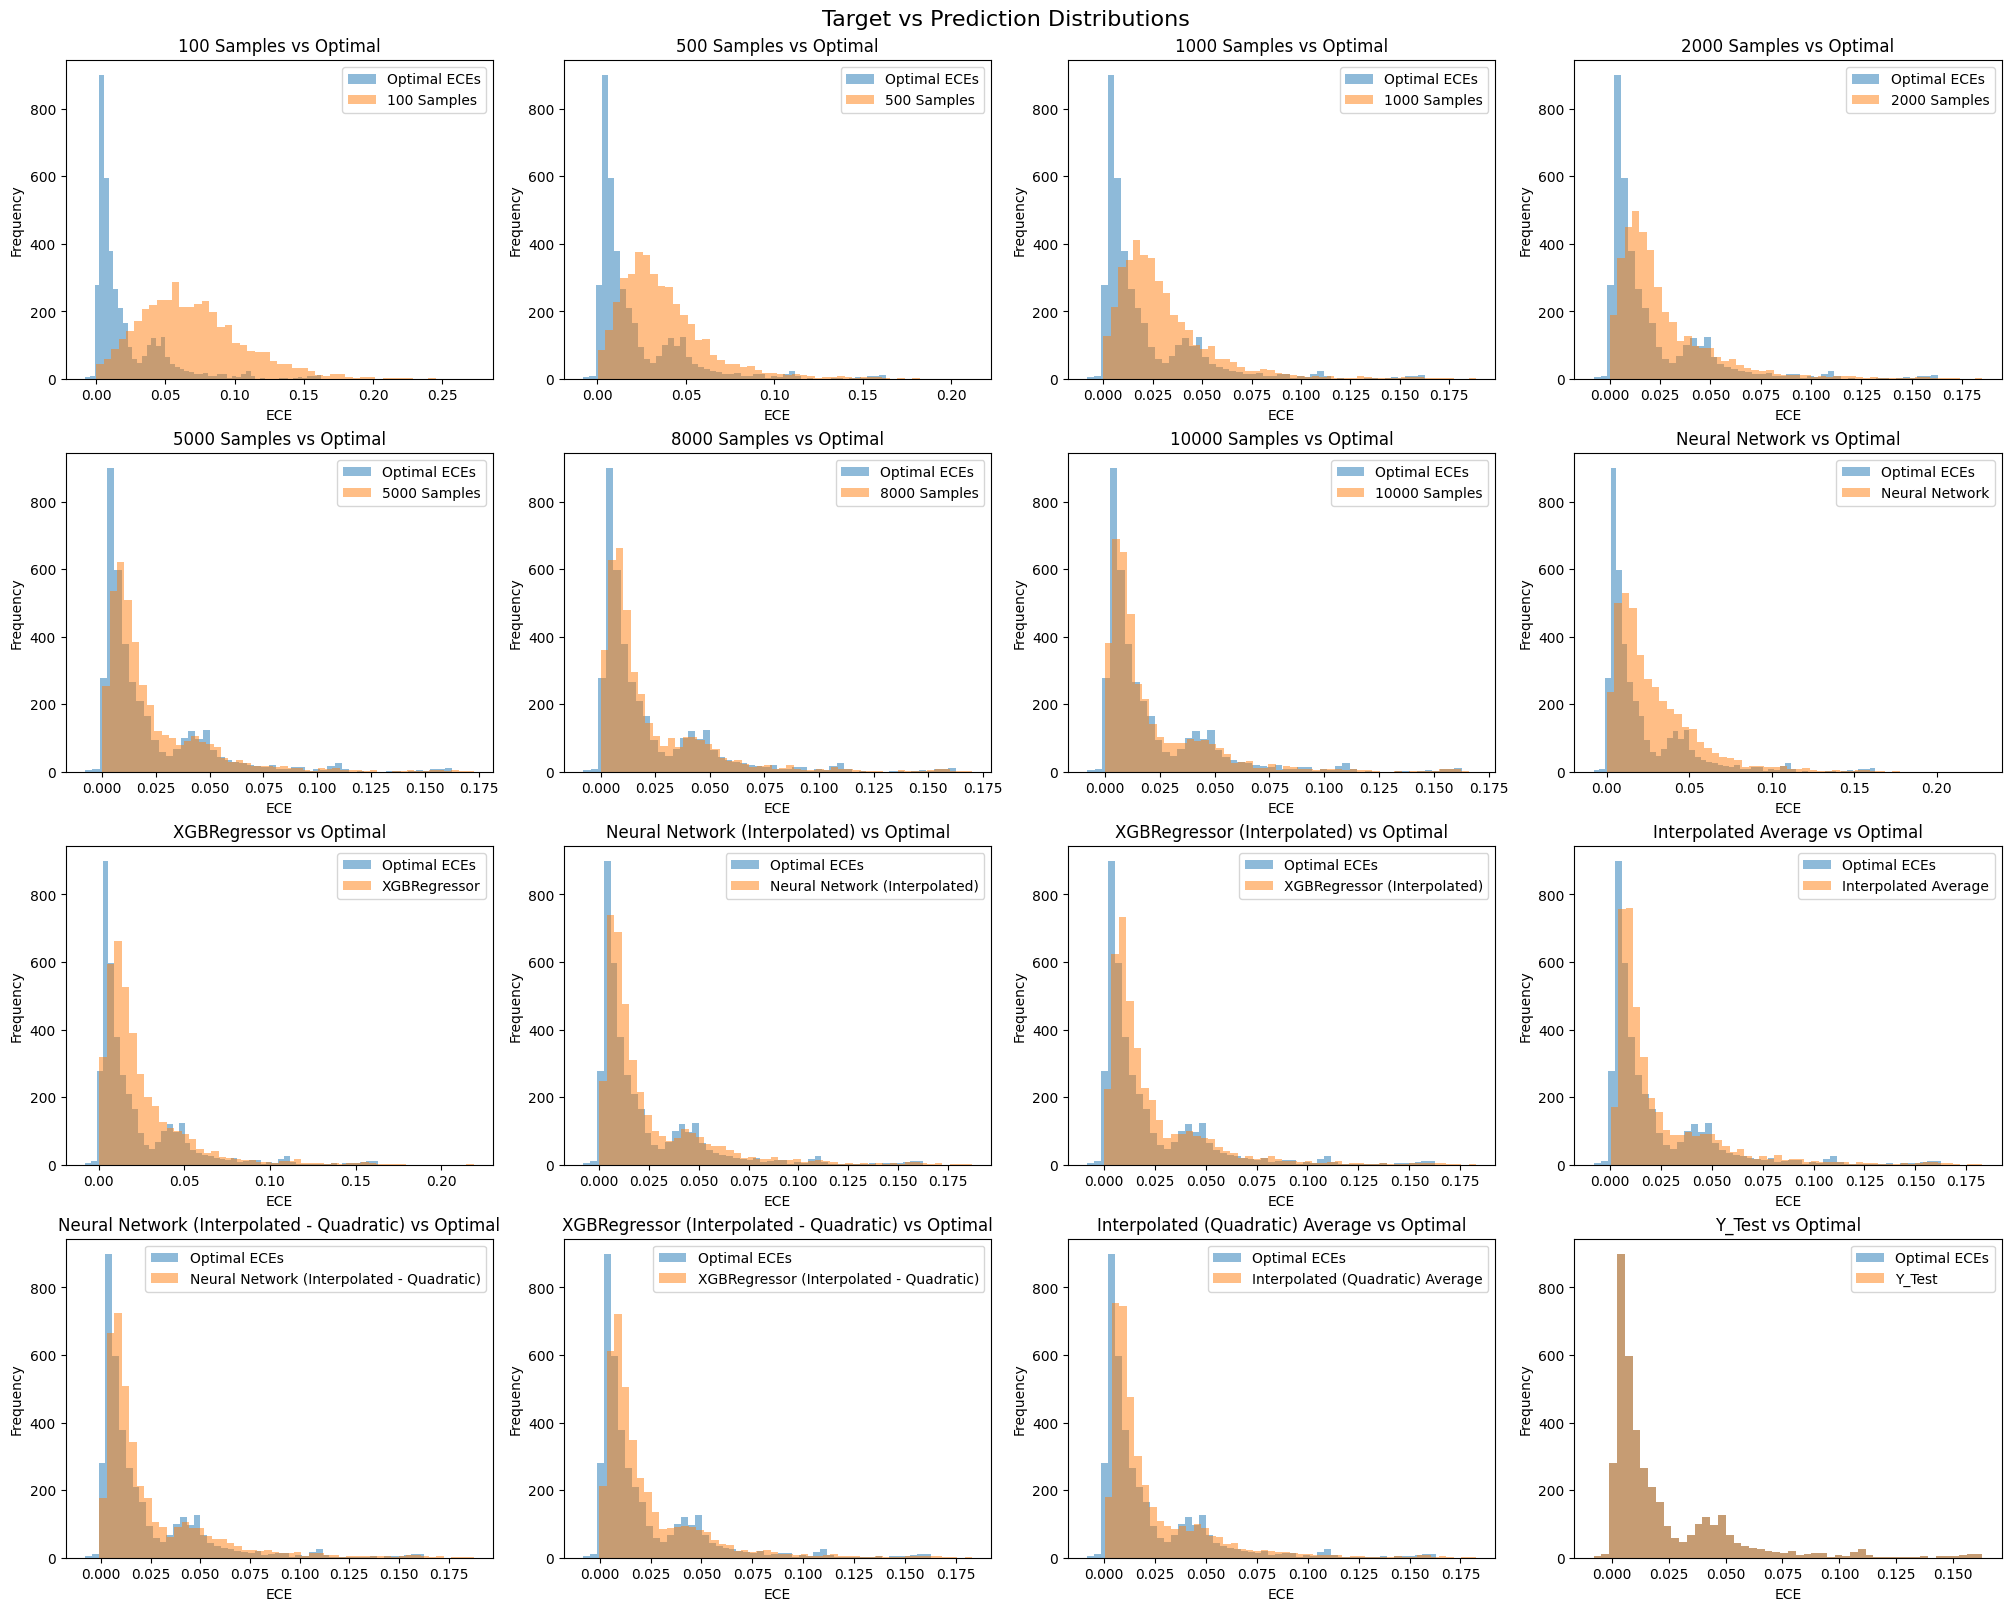

In [84]:
num_preds = len(preds)
cols = 4  # You can change this
rows = int(np.ceil(num_preds / cols))

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each prediction vs. optimal
for i, (key, value) in enumerate(preds.items()):
    ax = axs[i]
    if len(value) > 1:
        ax.hist(optimal_eces_test, bins=50, alpha=0.5, label="Optimal ECEs")
        ax.hist(value[1], bins=50, alpha=0.5, label=key)
        ax.set_title(f"{key} vs Optimal")
        ax.set_xlabel("ECE")
        ax.set_ylabel("Frequency")
        ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Target vs Prediction Distributions", fontsize=16)
plt.show()

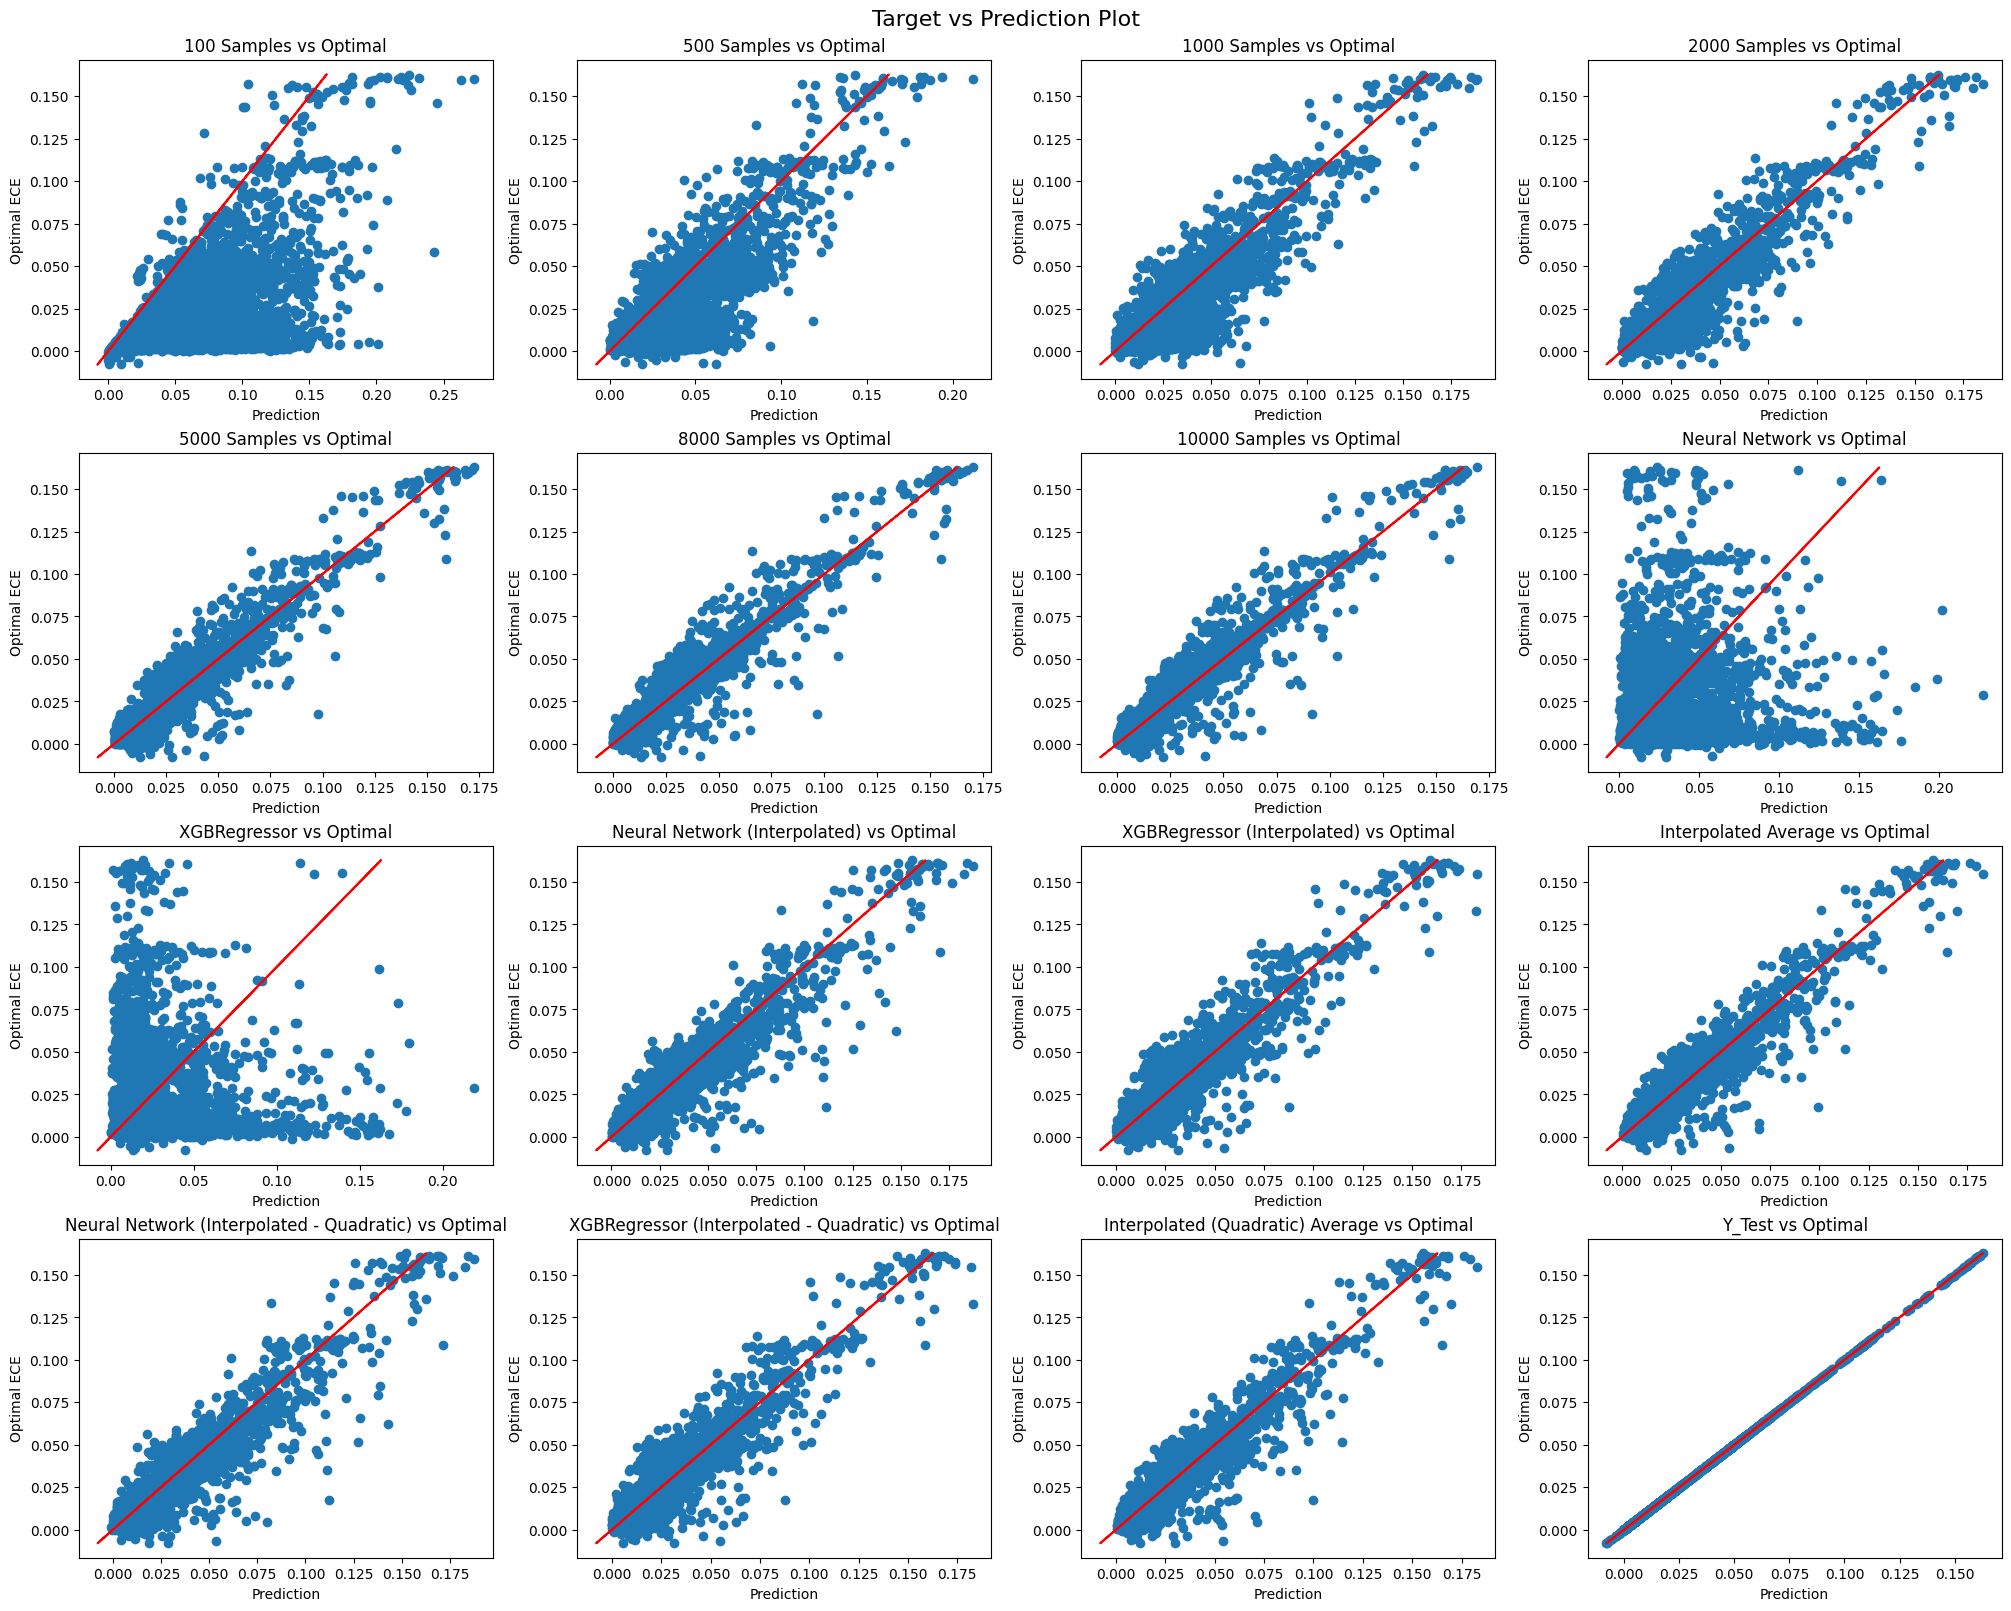

In [83]:
num_preds = len(preds)
cols = 4 
rows = int(np.ceil(num_preds / cols))

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axs = axs.flatten()

for i, (key, value) in enumerate(preds.items()):
    ax = axs[i]
    if len(value) > 1:
        ax.scatter(value[1], optimal_eces_test)
        ax.plot(optimal_eces_test, optimal_eces_test, c='red')
        ax.set_title(f"{key} vs Optimal")
        ax.set_xlabel("Prediction")
        ax.set_ylabel("Optimal ECE")

# Hide unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Target vs Prediction Plot", fontsize=16)
plt.show()